# Det and Segmentation

In [1]:
#@title necessary imports and classes
"""
File operations including downloading and extracting
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import shutil
import logging
import contextlib
import traceback
from urllib import request
from urllib.error import HTTPError
import gzip
from tqdm import tqdm
import numpy as np

logger = logging.getLogger(__name__)


class DownloadProgressBar(tqdm):
    """ Small helper class to make a download bar """

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


class FileOP:
    """
    Class for file operations including downloading, extracting and file size checking.

    Parameters:
    - data_output_dir (Optional[str]): The directory to store the downloaded files.

    Attributes:
    - data_output_dir (str): The directory to store the downloaded files.
    - url (None or str): The URL of the file to download.

    Methods:
    - unzip(in_file: str, out_file: str) -> int: Unzips a .gz file and returns the file size.
    - file_size_from_url(url: str) -> int: Gets the size of a file without downloading it.
    - download_from_url(url: str, download_dir: str, extract: bool = True, delete_after_extract: bool = False, ext_list: Optional[List[str]] = None) -> str: Downloads a file from a URL and
    * returns the file path.

    """
    def __init__(self, data_output_dir=None):
        self.data_output_dir = data_output_dir
        self.url = None

    def unzip(self, in_file, out_file):
        """
        Unzip .gz file and return file size
        :param in_file: complete file path of compressed .gz file
        :param out_file: complete file path of output file
        :return: os.path.getsize(out_file) in bytes
        """
        if not os.path.isfile(out_file):
            try:
                with gzip.open(in_file, 'rb') as f_in, open(out_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            except Exception as e:
                logger.error(f'gzip failed on file: {in_file}: {e}')
                print(f'gzip failed on file: {in_file}: {e}')
                file_size = None
            else:
                file_size = os.path.getsize(out_file)
        else:
            print(f'Uncompressed output file exists: {out_file}. Skipping.')
            file_size = os.path.getsize(out_file)
        return file_size

    def file_size_from_url(self, url):
        """
        Method to acquire size of a file without download
        :param: url
        :returns: size in bytes (int)
        """
        url_size = np.nan
        try:
            with contextlib.closing(request.urlopen(url)) as ul:
                url_size = ul.length
        except HTTPError as http_err:
            logger.error(f'ERROR: {http_err}: URL: {url}')
        except Exception as e:
            logger.error(f'ERROR {e}: URL: {url}')
        return url_size

    def download_from_url(self, url, download_dir, extract=True, delete_after_extract=False, ext_list=None):
        """
        :param url: cloud storage location URL
        :param download_dir: path-like object representing file path.
        :param extract: extract file if compressed
        :param delete_after_extract: if file is an archive, delete file after extraction.
        :param ext_list: list of allowed extensions, for example '.json.gz' or '.zip'
        :return: file path of output file
        """
        output_file_name = os.path.basename(url)
        if ext_list is not None:
            ext_in_url = [xt for xt in ext_list if xt in url]
            if len(ext_in_url) > 0:
                xt = ext_in_url[0]
                output_file_name = f'{output_file_name.split(xt, maxsplit=1)[0]}{xt}'
        output_file = os.path.join(download_dir, output_file_name)
        if os.path.exists(download_dir):
            if not os.path.exists(output_file):
                try:
                    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=output_file_name) as t:
                        request.urlretrieve(url, filename=output_file, reporthook=t.update_to)
                except HTTPError as http_err:
                    print(http_err)
                    logger.error(f'Download failed for URL: {url}'
                                 f' {http_err}')
                except Exception as e:
                    traceback.print_exc()
                    logger.error(f'Download failed for URL: {url}'
                                 f' {e}')
                else:
                    logger.info(f'Download complete: {output_file}.')
            else:
                logger.info(f'File exists: {output_file}')
            # Unpacking
            output_file_path = output_file
            if os.path.exists(output_file) and extract:
                file_parts = os.path.splitext(output_file)
                xt = file_parts[-1]
                if xt in ['.gz']:
                    print(f'Extracting from {xt} archive.')
                    out_file = file_parts[0]
                    file_size = self.unzip(in_file=output_file, out_file=out_file)
                    if file_size is not None:
                        output_file_path = out_file
                        if delete_after_extract:
                            os.unlink(output_file)
                            logger.info(f'Deleted compressed file {output_file}')
                elif xt in ['.json', '.csv', '.pickle', '.parquet', '.ckpt', '.pth']:
                    print(f'Created {xt} file.')
                else:
                    print(f'File: {xt} loaded.')
                    logger.warning(f'File extension is unexpected {xt}.')
            elif os.path.exists(output_file) and not extract:
                output_file_path = output_file
        else:
            logger.error(f'Output directory {download_dir} does not exist.')
            output_file_path = None
        return output_file_path

"""
Tools for working with the Dentex Challenge data
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import numpy as np
import logging
import tarfile
import json


logger = logging.getLogger(__name__)


def val_test_split(data, label_col=None, n_test_per_class=30, n_val_per_class=30, random_state=123):
    """
    Splits the given data into training, validation, and test sets based on the specified parameters.
    Args:
        data: A pandas DataFrame containing the data to be split.
        label_col: The name of the column in the data DataFrame that contains the labels.
        n_test_per_class: The number of samples per class to be allocated to the test set. Default is 30.
        n_val_per_class: The number of samples per class to be allocated to the validation set. Default is 30.
        random_state: The seed value used by the random number generator. Default is 123.
    Returns:
        A new pandas DataFrame with an additional column, 'dataset', indicating the split for each sample.
        The 'dataset' column will have one of the following values: 'train', 'val', or 'test'.
    """
    image_numbers = {'test': n_test_per_class,
                     'val': n_val_per_class}
    dset_df = data.copy().sample(frac=1, random_state=random_state). \
        assign(dataset=None).reset_index(drop=True)
    for dataset in image_numbers.keys():
        if label_col is not None:
            labels = dset_df[label_col].unique()
            for label in labels:
                np.random.seed(random_state)
                idx_list = np.random.choice(dset_df. \
                                            loc[(dset_df[label_col] == label) & (dset_df['dataset'].isnull())]. \
                                            index, size=image_numbers.get(dataset), replace=False)
                dset_df.loc[dset_df.index.isin(idx_list), 'dataset'] = dataset
        else:
            np.random.seed(random_state)
            idx_list = np.random.choice(dset_df.
                                        loc[dset_df['dataset'].isnull()].
                                        index, size=image_numbers.get(dataset), replace=False)
            dset_df.loc[dset_df.index.isin(idx_list), 'dataset'] = dataset

    # Use the remaining samples for training
    dset_df.loc[dset_df['dataset'].isnull(), 'dataset'] = 'train'
    return dset_df


class DentexData:
    def __init__(self, data_dir):
        self.annotations_file = None
        self.annotations = None
        self.data_dir = data_dir
        self.classification_url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration-disease.tar.gz'
        self.detection_url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz'
        if not os.path.exists(self.data_dir):
            logger.warning('Data directory does not exist')

    def create_category_dict(self, categories=None):
        """
        Create a dictionary of categories.
        :param categories: A list of category IDs. Default is None.
        :type categories: list, optional
        :return: A dictionary containing category names as keys and a sub-dictionary as values.
                 The sub-dictionary contains category IDs as keys and category names as values.
        :rtype: dict
        """
        if categories is None:
            categories = range(1, 4)
        category_dict = {}
        if self.annotations is not None:
            for category_id in categories:
                category_name = f'categories_{category_id}'
                cat_list = self.annotations.get(category_name)
                id_list = [c.get('id') for c in cat_list]
                nm_list = [c.get('name') for c in cat_list]
                category_dict.update({category_name: dict(zip(id_list, nm_list))})
        else:
            logger.warning('No annotations. Run "load_annotations" method first.')
        return category_dict

    def download_image_data(self, url):
        """
        Downloads image data from a specified URL
        Parameters:
        - url (str): The URL from which to download the image data.
        If not provided, the method will use the default classification URL.
        Returns:
        - data_tar_file (str): The path to the downloaded data TAR file.
        Raises:
        - ValueError: If an incomplete file exists at the specified URL.
        Example usage:
        download_image_data(url='https://www.example.com/data.tar')
        """
        data_tar_file = FileOP().download_from_url(url=url, download_dir=self.data_dir)
        if data_tar_file is not None and os.path.exists(data_tar_file):
            try:
                with tarfile.open(data_tar_file) as tar:
                    tar.extractall(path=self.data_dir)
            except Exception as e:
                logger.error(f'Could not extract: {e}')
        return data_tar_file

    def load_annotations(self, json_file):
        try:
            with open(json_file, 'r') as f:
                self.annotations = json.load(f)
                self.annotations_file = json_file
        except IOError as e:
            logger.error(f'Could not read {json_file}: {e}')
        return self.annotations

"""
Methods for image processing
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import copy
import numpy as np
import cv2
import logging
from skimage import io
from PIL import Image

logger = logging.getLogger(name=__name__)


def clip_range(r, max_val):
    return max(min(r, max_val), 0)


def transform_box(box_padded, pad_pixels, img):
    """
    Transform bounding box from padded to original image
    """
    img_h, img_w = img.shape[:2]
    x, y, w, h = box_padded - float(pad_pixels)
    output_box = tuple([clip_range(x, img_w),
                        clip_range(y, img_h),
                        clip_range(w, img_w),
                        clip_range(h, img_h)])
    return output_box


def crop_image(image, box):
    """
    Crops an object in an image by bounding box
    :Parameters:
        image: (np.ndarray) image data
        box: (tuple) (x_min, y_min, width, height)
    :returns:
        crop_img: (np.ndarray) cropped image
    """
    x, y, w, h = [int(np.round(c)) for c in box]
    return image[y:h, x:w, :]


def is_image(image_file_path):
    """
    Checks if the given file path corresponds to an image file.
    Parameters:
        image_file_path (str): The path to the file.
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    file_is_image = False
    if os.path.exists(image_file_path):
        try:
            Image.open(image_file_path)
        except Exception as ex:
            logger.warning(f'File: {image_file_path} is not an image.')
        else:
            file_is_image = True
    else:
        logger.warning(f'File: {image_file_path} does not exist.')
    return file_is_image


def validate_image_data(data_df, file_path_col):
    """ Load and validate images from data frame
    :parameters:
        data_df (pd.DataFrame): data frame with image file paths
        file_path_col (list): List of columns with file paths
    :returns
        output_df (pd.DataFrame): data frame with valid file paths
    """
    output_df = copy.deepcopy(data_df)
    file_path_col = [file_path_col] if isinstance(file_path_col, str) else file_path_col
    for col in file_path_col:
        n_start = len(output_df)
        output_df = output_df.loc[output_df[col].apply(is_image)]
        n_dropped = n_start - len(output_df)
        if n_dropped > 0:
            warning_msg = f'Dropped {n_dropped} rows from bad data in column: {col}.'
            logger.warning(warning_msg)
        else:
            logger.info('All files validated.')
    return output_df


class ImageData:
    """ Load and transform images """

    def __init__(self, resize=None):
        self.resize = resize
        self.image_net_mean = [0.485, 0.456, 0.406]
        self.image_net_std = [0.229, 0.224, 0.225]

    def load_image(self, image_path):
        """ Load image as np.ndarray
        Parameters:
            image_path: (str) complete path to image file
        Returns:
            output_array: (np.ndarray) (uint8)
        """
        output_array = None
        if os.path.exists(image_path):
            try:
                with open(image_path, mode='rb') as fl:
                    img = io.imread(fl)
            except Exception as ex:
                read_error_msg = f'Unable to read: {image_path}'
                print(read_error_msg)
                logger.error(read_error_msg)
            else:
                output_array = img.astype(np.uint8)
        else:
            error_msg = f'Image file: {image_path} does not exist.'
            print(error_msg)
            logger.error(error_msg)
        return output_array

    def image_size(self, image_path):
        """ Load image and return size in pixels (height, width) """
        output = None
        if is_image(image_path):
            output_array = self.load_image(image_path)
            if output_array is not None:
                output = tuple(output_array.shape)
        return output

    def np_square_pad(self, im_array, pad_pixels, pad_number=0):
        """ Pad 2D image
        Parameters:
            im_array: (np.ndarray) 2D numpy array
            pad_pixels: (int) pixels to add on each side
            pad_number: (int) gray value in [0, 256]
        """
        assert len(im_array.shape) == 2, f'Require 2D grayscale image.'

        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value

        output = np.pad(im_array, pad_pixels, pad_with, padder=pad_number)
        return output

    def np2color(self, im_array, color_scheme='RGB'):
        """ Convert np.ndarray into color image
        Parameters:
            im_array: (np.ndarray) 2D or 3D numpy array
            color_scheme: (str) 'RGB', 'BGR' or 'GRAY'
        """
        assert color_scheme in ['RGB', 'BGR', 'GRAY'], f'color_scheme must be RGB, BGR or GRAY'
        if len(im_array.shape) == 2:
            color_code_str = f'cv2.COLOR_GRAY2{color_scheme}'
            image = cv2.cvtColor(im_array, code=eval(color_code_str))
        elif len(im_array.shape) == 3:
            if color_scheme == 'RGB':
                image = im_array.copy()
            else:
                color_code_str = f'cv2.COLOR_RGB2{color_scheme}'
                image = cv2.cvtColor(im_array, code=eval(color_code_str))
        else:
            raise NotImplementedError('input array must be 2D or 3D.')
        return image

    def convert_transparent_png(self, img):
        """ Decomposing the alpha channel for 4 channel png file """
        # image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        output_image = img
        if len(img.shape) == 3 and img.shape[2] == 4:
            alpha_channel = img[:, :, 3]
            rgb_channels = img[:, :, :3]
            white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255
            alpha_factor = alpha_channel[:, :, np.newaxis].astype(np.float32) / 255.0
            alpha_factor = np.concatenate((alpha_factor, alpha_factor, alpha_factor), axis=2)
            base = rgb_channels.astype(np.float32) * alpha_factor
            white = white_background_image.astype(np.float32) * (1 - alpha_factor)
            output_image = (base + white).astype(np.uint8)
        return output_image

    def resize_image_list(self, image_list, output_size):
        """ Match size for multiple inputs before augmentation
        Parameters:
            image_list, list of images
            output_size, int or tuple, size of output image
        """
        assert any([isinstance(output_size, int),
                    isinstance(output_size, tuple)]), 'output_size must be of type int or tuple.'

        if isinstance(output_size, int):
            dim = (output_size, output_size)
        else:
            dim = output_size

        output_image_list = [cv2.resize(im, dim, interpolation=cv2.INTER_AREA) for im in image_list]
        return output_image_list

    def hist_eq(self, img):
        """ Adaptive histogram equalization
        Parameters:
            img (np.ndarray) RGB image
        Returns:
            enhanced_img (np.ndarray) RGB image with enhanced contrast
        """
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)
        lim_g = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(lim_g, cv2.COLOR_LAB2RGB)
        return enhanced_img


In [2]:
!pip install python-dotenv

In [3]:
# Imports
import os
import numpy as np
import pandas as pd
import tarfile
import random
import time
import glob
import json
from pathlib import Path
from dotenv import load_dotenv

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


In [4]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')
Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(model_dir).mkdir(parents=True, exist_ok=True)

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [5]:
# Create an instance of the DentexData class
dtx = DentexData(data_dir=data_dir)
url = dtx.detection_url
sz = FileOP().file_size_from_url(url)
sz_GB = sz/1.0e9

# Download and extract the data
print(f'Downloading {sz_GB:.2f} GB from:\n{url}')
data_tar_file = dtx.download_image_data(url=url)

# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 634
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Extracted {len(file_list)} images.')

https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz


dentex-quadrant-enumeration.tar.gz: 1.72GB [00:38, 44.6MB/s]                            


Extracting from .gz archive.
Extracted 634 images.


In [6]:
# Create a data frame with the image file paths
file_name_list = [os.path.basename(file) for file in file_list]
im_number_list = [int(os.path.splitext(file)[0].rsplit('_', maxsplit=1)[-1]) for file in file_name_list]
files = pd.DataFrame({'image_number': im_number_list,
                      'file_name': file_name_list,
                      'file_path': file_list}).\
                sort_values(by='image_number', ascending=True).reset_index(drop=True)

display(files.head())

,image_number,file_name,file_path
0,0,train_0.png,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
1,1,train_1.png,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
2,2,train_2.png,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
3,3,train_3.png,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
4,4,train_4.png,DATA_ROOT/dentex/dentex_detection/quadrant_enu...


In [7]:
# Load the annotation file
annotation_file = os.path.join(data_dir,
                               'quadrant_enumeration',
                               'train_quadrant_enumeration.json')
annotations = dtx.load_annotations(annotation_file)
print(f'Loaded annotations from file:\n{dtx.annotations_file}\n{annotations.keys()}')

Loaded annotations from file:
DATA_ROOT/dentex/dentex_detection/quadrant_enumeration/train_quadrant_enumeration.json
dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])


In [8]:
# Add image ids to the files data frame
js_im_df = pd.DataFrame(annotations.get('images')).\
                merge(files, on='file_name', how='inner').\
                sort_values(by='id', ascending=True).\
                reset_index(drop=True).\
                rename(columns={'id': 'image_id'}).\
                drop(['height', 'width'], axis=1)
display(js_im_df.head())
print(js_im_df.shape)

,image_id,file_name,image_number,file_path
0,1,train_283.png,283,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
1,2,train_435.png,435,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
2,3,train_95.png,95,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
3,4,train_475.png,475,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
4,5,train_62.png,62,DATA_ROOT/dentex/dentex_detection/quadrant_enu...


(634, 4)


In [9]:
# Create a dictionary of categories with IDs and names
# The categories are described in a dictionary at the top of the JSON file
display(dtx.annotations.keys())
print()
# We can create one dictionary with the labels for each annotation
# Annotations are quadrant (categories_1) and tooth position (categories_2).
categories = dtx.create_category_dict(categories=range(1, 3))
display(categories)

dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])

{'categories_1': {0: 1, 1: 2, 2: 3, 3: 4},
 'categories_2': {0: '1',
  1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8'}}

In [10]:
# Save the data frame with the file paths and annotations
df_file_name = 'dentex_detection_dataset.parquet'
df_file = os.path.join(data_dir, df_file_name)
js_im_df.to_parquet(df_file)
print(f'Annotation data frame saved: {df_file}')

Annotation data frame saved: DATA_ROOT/dentex/dentex_detection/dentex_detection_dataset.parquet


In [11]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

# Data frame with images and paths
data_df_file_name = 'dentex_detection_dataset.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

In [12]:
# Load the data frame with image paths and bounding boxes
data_df = pd.read_parquet(data_df_file)
display(data_df.head(2))
# Create an instance of the DentexData class
dtx = DentexData(data_dir=data_dir)

,image_id,file_name,image_number,file_path
0,1,train_283.png,283,DATA_ROOT/dentex/dentex_detection/quadrant_enu...
1,2,train_435.png,435,DATA_ROOT/dentex/dentex_detection/quadrant_enu...


In [13]:
# Function to create the data splits
label_col = 'label'
dset_df = val_test_split(data=data_df,
                         n_test_per_class=50,
                         n_val_per_class=50)

In [14]:
train_set = set(dset_df.loc[dset_df['dataset'] == 'train', 'file_name'].values)
print(f'We have {len(train_set)} images in the train set.')

val_set = set(dset_df.loc[dset_df['dataset'] == 'val', 'file_name'].values)
print(f'We have {len(val_set)} images in the validation set.')

test_set = set(dset_df.loc[dset_df['dataset'] == 'test', 'file_name'].values)
print(f'We have {len(test_set)} images in the test set.')

# Make sure that these data sets are distinct
print(train_set.intersection(val_set))
print(train_set.intersection(test_set))
print(val_set.intersection(test_set))

We have 534 images in the train set.
We have 50 images in the validation set.
We have 50 images in the test set.
set()
set()
set()


In [15]:
# Save the data split
datasplit_file_name = 'dentex_detection_datasplit.parquet'
datasplit_file = os.path.join(data_dir, datasplit_file_name)
dset_df.to_parquet(datasplit_file)
print(datasplit_file)
display(dset_df.head())

DATA_ROOT/dentex/dentex_detection/dentex_detection_datasplit.parquet


,image_id,file_name,image_number,file_path,dataset
0,327,train_612.png,612,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,train
1,543,train_163.png,163,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,train
2,152,train_243.png,243,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,train
3,135,train_436.png,436,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,train
4,309,train_483.png,483,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,train


In [16]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-usnsddj_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-usnsddj_
  Resolved https://github.com/facebookresearch/detectron2.git to commit 28fd05eeb68114aa8a8d915168bdf6e7f7b5c2a6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [17]:
# Detectron2 library
import detectron2
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [18]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

# Data frame with data splits
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

In [19]:
data_df = pd.read_parquet(data_df_file)

train_set = set(data_df.loc[data_df['dataset'] == 'train', 'file_name'].values)
print(f'We have {len(train_set)} images in the train set.')

val_set = set(data_df.loc[data_df['dataset'] == 'val', 'file_name'].values)
print(f'We have {len(val_set)} images in the validation set.')

test_set = set(data_df.loc[data_df['dataset'] == 'test', 'file_name'].values)
print(f'We have {len(test_set)} images in the test set.')

We have 534 images in the train set.
We have 50 images in the validation set.
We have 50 images in the test set.


In [20]:
# Open the json annotation file
# We cannot use this file directly, because we will train a Faster R-CNN model
# This requires a little different annotation representations

annotation_file_name = 'train_quadrant_enumeration.json'
json_file = os.path.join(data_dir, 'quadrant_enumeration', annotation_file_name)

dtx = DentexData(data_dir=data_dir)
annotations = dtx.load_annotations(json_file=json_file)
display(annotations.keys())

# Create one dictionary with all annotation categories
category_dict = dtx.create_category_dict(categories=range(1, 3))
display(category_dict)

dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])

{'categories_1': {0: 1, 1: 2, 2: 3, 3: 4},
 'categories_2': {0: '1',
  1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8'}}

In [21]:
def create_rcnn_anntations(annotations, file):
    """
    Create RCNN annotations for a given file.
    Parameters:
    - annotations (dict): The annotations dictionary containing information about images and annotations.
    - file (str): The path of the file for which RCNN annotations are to be created.
    Returns:
    - dict: The image annotation dictionary with RCNN annotations.
    """
    file_name = os.path.basename(file)
    im_annotation = {}
    # Verify that the image exists
    if is_image(file):

        # Find the image annotation
        im_annotation = [dct.copy() for dct in annotations.get('images') if dct.get('file_name') == file_name][0]

        # Replace the file_name field in the annotation dictionary with the full path
        im_annotation.update({'file_name': file})

        # We also need an 'image_id' field. We can replace the original id.
        image_id = im_annotation.get('id')
        im_annotation.update({'image_id': image_id})
        im_annotation.pop('id')

        # Find the list of annotations for one image
        annotation_list = [an_dict for an_dict in annotations.get('annotations') if an_dict.get('image_id') == image_id]

        # We pull out just the information that we need into a new list
        record_list = []
        for an_dict in annotation_list:
            im_dict = {'id': an_dict.get('id'),
                       'area': an_dict.get('area'),
                       'iscrowd': an_dict.get('iscrowd'),
                       'bbox': an_dict.get('bbox'),
                       'bbox_mode': BoxMode.XYWH_ABS,
                       'segmentation': an_dict.get('segmentation'),
                       'category_id': 0}
            record_list.append(im_dict)

        # Add this list of annotations to the image annotation dictionary
        im_annotation.update({'annotations': record_list})

    return im_annotation

In [22]:
datasets = data_df['dataset'].unique()
annotation_dict = {}
for d, dataset in enumerate(datasets):
    annotation_list = []
    print(f'Annotations for dataset {d+1}/{len(datasets)} "{dataset}"')
    dataset_df = data_df.loc[data_df['dataset'] == dataset]
    file_name_list = sorted(list(dataset_df['file_name'].unique()))
    for f, file_name in enumerate(file_name_list):
        if (f+1) % 100 == 0:
            print(f'Creating annotations for file {f+1}/{len(file_name_list)}')
        file = os.path.join(image_dir, file_name)
        im_annotation = create_rcnn_anntations(annotations=annotations, file=file)
        annotation_list.append(im_annotation)
    annotation_dict.update({dataset: annotation_list})
print(annotation_dict.keys())

# Save the annotation files
#data_df_file_name = 'dentex_detection_datasplit.parquet'
for dataset, annotation_list in annotation_dict.items():
    json_file_name = f'dentex_detection_{dataset}.json'
    json_file = os.path.join(data_dir, json_file_name)
    with open(json_file, 'w') as fl:
        json.dump(annotation_list, fl, indent=4)
    print(f'Saved annotations for dataset "{dataset}": {json_file}')

Annotations for dataset 1/3 "train"
Creating annotations for file 100/534
Creating annotations for file 200/534
Creating annotations for file 300/534
Creating annotations for file 400/534
Creating annotations for file 500/534
Annotations for dataset 2/3 "val"
Annotations for dataset 3/3 "test"
dict_keys(['train', 'val', 'test'])
Saved annotations for dataset "train": DATA_ROOT/dentex/dentex_detection/dentex_detection_train.json
Saved annotations for dataset "val": DATA_ROOT/dentex/dentex_detection/dentex_detection_val.json
Saved annotations for dataset "test": DATA_ROOT/dentex/dentex_detection/dentex_detection_test.json


In [23]:
dataset_list = ['train', 'val', 'test']
annotation_name_list = [f'dentex_detection_{dataset}.json' for dataset in dataset_list]
annotation_file_list = [os.path.join(data_dir, file_name) for file_name in annotation_name_list]
annotation_file_dict = dict(zip(dataset_list, annotation_file_list))
annotation_dict = {}

for dataset, annotation_file in annotation_file_dict.items():
    try:
        with open(annotation_file, 'r') as fl:
            annotations = json.load(fl)
    except FileNotFoundError:
        print(f'Annotation file not found: {annotation_file}')
        print('Make sure to run the annotations notebook.')
    else:
        annotation_dict.update({dataset: annotations})
        print(f'Loaded annotations for {len(annotations)} images for dataset "{dataset}".')

# Register the data sets
for dataset in dataset_list:
    if dataset not in DatasetCatalog:
        DatasetCatalog.register(name=dataset, func=lambda d=dataset: annotation_dict.get(d))
        MetadataCatalog.get(dataset).set(thing_classes=['tooth'])

Loaded annotations for 534 images for dataset "train".
Loaded annotations for 50 images for dataset "val".
Loaded annotations for 50 images for dataset "test".


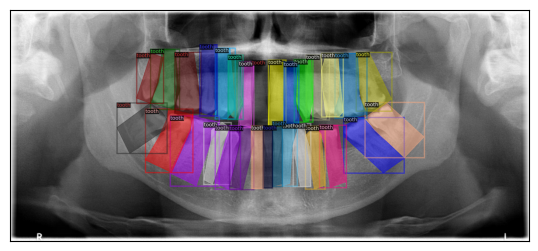

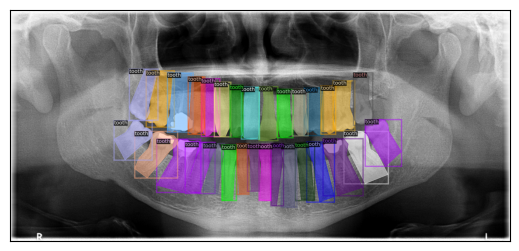

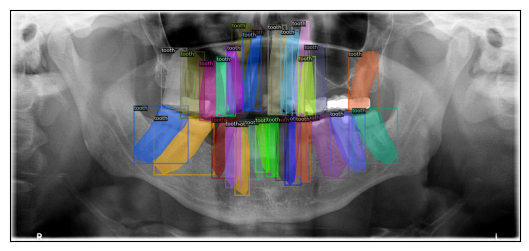

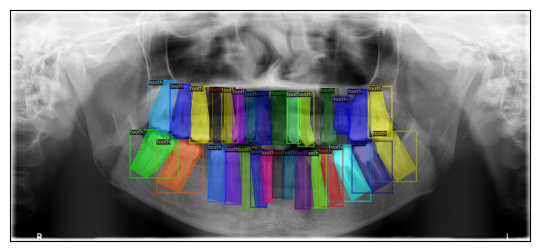

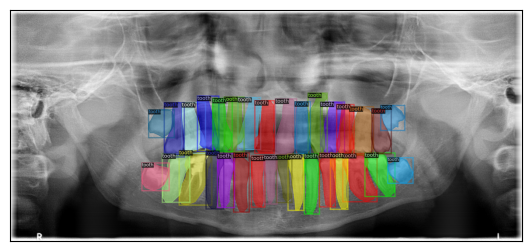

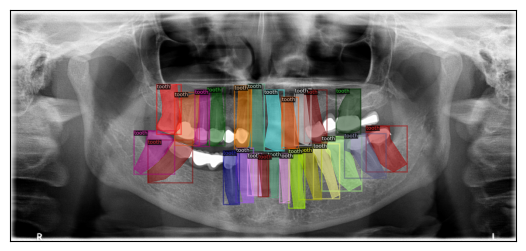

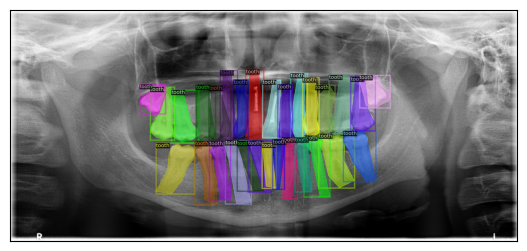

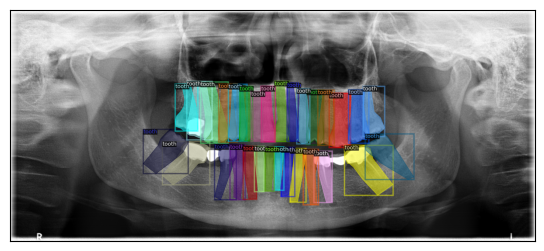

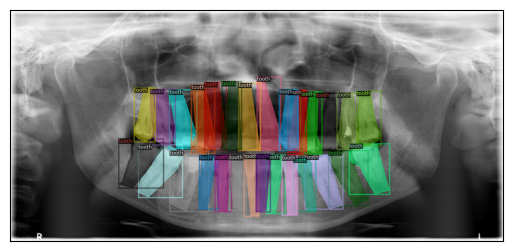

<function matplotlib.pyplot.close(fig=None)>

In [24]:
def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

output_dir = os.path.join(data_dir, 'output')
Path(output_dir).mkdir(exist_ok=True, parents=True)

# Load one image from each data set
n_images_per_dataset = 3
for dataset in dataset_list:
    for example_idx in range(n_images_per_dataset):
        an_dict = DatasetCatalog.get(dataset)[example_idx]
        metadata = MetadataCatalog.get(dataset)
        file = an_dict.get('file_name')
        file_name = os.path.basename(file)
        im = ImageData().load_image(file)
        vs = Visualizer(img_rgb=im, metadata=metadata, scale = 1.0)
        vs = vs.draw_dataset_dict(an_dict).get_image()
        fig, ax = show_image(vs, figsize=(9, 3))
        image_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
        plt.savefig(os.path.join(output_dir, image_name), bbox_inches='tight')
        plt.show()
plt.close

In [25]:
# Imports

import os
import numpy as np
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt
from pathlib import Path

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [26]:
#@title import lib

"""
Classes to support training and evaluation of the detectron2 models
Andreas Werdich
Center for Computational Biomedicine
"""
import os
import time
import datetime
import logging
import torch
import numpy as np
from detectron2.data import build_detection_test_loader, DatasetMapper
from detectron2.evaluation import COCOEvaluator
from detectron2.utils import comm
from detectron2.engine import HookBase, DefaultTrainer
from detectron2.utils.logger import log_every_n_seconds

logger = logging.getLogger(name=__name__)


def file_assert(file, log_only=True):
    """
    Check if a file exists in the system.
    """
    file_exist = False
    try:
        assert os.path.exists(file)
    except AssertionError as err:
        msg = f'File {file} not found.'
        logger.warning(msg)
        if not log_only:
            print(msg)
    else:
        file_exist = True
    return file_exist


class Trainer(DefaultTrainer):
    """
    Class: Trainer
    Inherits from: DefaultTrainer
    Description:
    This class is responsible for training and evaluating a model using the Detectron2 library.
    Methods:
    1. build_evaluator(cls, cfg, dataset_name, eval_output_dir=None):
        - Description: Builds an evaluator for the given dataset using the COCOEvaluator class.
        - Parameters:
            - cls: The class itself.
            - cfg: The configuration object for the model.
            - dataset_name: The name of the dataset to evaluate.
            - eval_output_dir: The directory to save the evaluation output. Default is None.
        - Returns: The evaluator object.

    2. build_hooks(self):
        - Description: Builds and returns a list of hooks to be used during training.
        - Parameters: None
        - Returns: A list of hooks.
    """
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, eval_output_dir=None):
        if eval_output_dir is None:
            eval_output_dir = os.path.join(cfg.OUTPUT_DIR, 'eval')
        evaluator = COCOEvaluator(dataset_name=dataset_name,
                                  tasks=('bbox',),
                                  distributed=False,
                                  output_dir=eval_output_dir)
        return evaluator

    def build_hooks(self):
        hooks = super().build_hooks()
        data_loader = build_detection_test_loader(self.cfg,
                                                  self.cfg.DATASETS.TEST[0],
                                                  DatasetMapper(self.cfg, is_train=True))

        hooks.insert(-1, LossEvalHook(eval_period=self.cfg.TEST.EVAL_PERIOD,
                                      model=self.model,
                                      data_loader=data_loader))
        return hooks


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    'Loss on Validation done {}/{}. {:.4f} s / img. ETA={}'.
                    format(idx + 1, total, seconds_per_img, str(eta)), n=5, )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [27]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [28]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

# Data frame with data splits
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

In [29]:
# Annotation files (and make sure the files are where they should be.
annotation_files = {}
dataset_list = ['train', 'val', 'test']
annotation_name_list = [f'dentex_detection_{dataset}.json' for dataset in dataset_list]
annotation_file_list = [os.path.join(data_dir, file_name) for file_name in annotation_name_list]
annotation_file_dict = dict(zip(dataset_list, annotation_file_list))
for dataset, annotation_file in annotation_file_dict.items():
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f'Annotation "{json_file}" not found.')
    else:
        annotation_files.update({dataset: annotation_file})
display(annotation_files)

{'train': 'DATA_ROOT/dentex/dentex_detection/dentex_detection_train.json',
 'val': 'DATA_ROOT/dentex/dentex_detection/dentex_detection_val.json',
 'test': 'DATA_ROOT/dentex/dentex_detection/dentex_detection_test.json'}

In [30]:
annotation_dict = {}
for dataset, annotation_file in annotation_file_dict.items():
    try:
        with open(annotation_file, 'r') as fl:
            annotations = json.load(fl)
    except FileNotFoundError:
        print(f'Annotation file not found: {annotation_file}')
        print('Make sure to run the annotations notebook.')
    else:
        annotation_dict.update({dataset: annotations})
        print(f'Loaded annotations for {len(annotations)} images for dataset "{dataset}".')

# Register the data sets
for dataset in dataset_list:
    dataset_name = f'dentex_{dataset}'
    if dataset_name not in DatasetCatalog:
        DatasetCatalog.register(name=dataset_name, func=lambda d=dataset: annotation_dict.get(d))
        MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

Loaded annotations for 534 images for dataset "train".
Loaded annotations for 50 images for dataset "val".
Loaded annotations for 50 images for dataset "test".


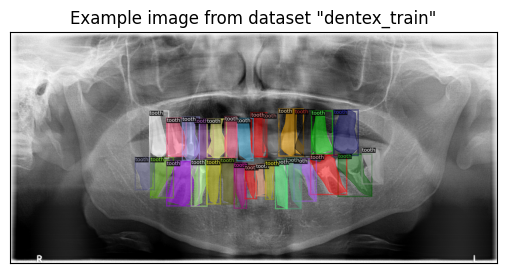

In [31]:
# Plot one image from the training set
def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

# Load one random image from the training set
dataset = 'dentex_train'
image_list = DatasetCatalog.get(dataset)
image_dict = np.random.choice(image_list, size=1)[0]
metadata = MetadataCatalog.get(dataset)
im = ImageData().load_image(image_dict.get('file_name'))
vs = Visualizer(img_rgb=im, metadata=metadata, scale = 1.0)
vs = vs.draw_dataset_dict(image_dict).get_image()
fig, ax = show_image(vs, figsize=(12, 3), title=f'Example image from dataset "{dataset}"')
plt.show()

In [32]:
# Model definition
# For a description, see https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
# https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml
model_config = os.path.join('COCO-Detection', 'faster_rcnn_R_101_FPN_3x.yaml')

# Build configuration file
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_config))

# Output directory
model_name = 'Toothdetector'
model_version = 1
model_output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')
Path(model_output_dir).mkdir(parents=True, exist_ok=True)

# Set the names for the datasets (as registered)
cfg.DATASETS.TRAIN = ('dentex_train', )
cfg.DATASETS.TEST = ('dentex_val', )
cfg.TEST.EVAL_PERIOD = 100
# The numbers of workers you can use depends on the number of cores and memory available per core
# Four workes is good for 32G memory
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)
# The batch size needs to be adjusted according to the GPU memory
# A batch size of 4 works for and 8 GB GPU
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = []
# Train for at least 3,000 iterations to get good results
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = model_output_dir

# Train on GPU or CPU
cfg.MODEL.DEVICE = device.type

# Save the config file before training
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(model_output_dir, model_config_file_name)
with open(model_config_file, mode='w') as fl:
    fl.write(cfg.dump())

In [33]:
# Train the model
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/14 09:33:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 152MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/14 09:33:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/14 09:33:39 d2.utils.events]:  eta: 0:08:53  iter: 19  total_loss: 4.619  loss_cls: 0.704  loss_box_reg: 0.5578  loss_rpn_cls: 2.96  loss_rpn_loc: 0.2854    time: 0.5608  last_time: 0.5932  data_time: 0.0268  last_data_time: 0.0084   lr: 4.9953e-06  max_mem: 5368M
[10/14 09:33:53 d2.utils.events]:  eta: 0:08:43  iter: 39  total_loss: 2.026  loss_cls: 0.664  loss_box_reg: 0.8021  loss_rpn_cls: 0.3192  loss_rpn_loc: 0.2469    time: 0.5618  last_time: 0.5705  data_time: 0.0088  last_data_time: 0.0088   lr: 9.9902e-06  max_mem: 5368M
[10/14 09:34:05 d2.utils.events]:  eta: 0:08:52  iter: 59  total_loss: 1.754  loss_cls: 0.621  loss_box_reg: 0.8399  loss_rpn_cls: 0.08467  loss_rpn_loc: 0.2189    time: 0.5657  last_time: 0.5720  data_time: 0.0087  last_data_time: 0.0086   lr: 1.4985e-05  max_mem: 5368M
[10/14 09:34:16 d2.utils.events]:  eta: 0:08:42  iter: 79  total_loss: 1.7  loss_cls: 0.5707  loss_box_reg: 0.832  loss_rpn_cls: 0.07633  loss_rpn_loc: 0.2037    time: 0.5667  last_time: 0

In [34]:
# Imports
import os
import numpy as np
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt
from pathlib import Path

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [35]:
#@title necessary imports and classes
"""
File operations including downloading and extracting
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import shutil
import logging
import contextlib
import traceback
from urllib import request
from urllib.error import HTTPError
import gzip
from tqdm import tqdm
import numpy as np

logger = logging.getLogger(__name__)


class DownloadProgressBar(tqdm):
    """ Small helper class to make a download bar """

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


class FileOP:
    """
    Class for file operations including downloading, extracting and file size checking.

    Parameters:
    - data_output_dir (Optional[str]): The directory to store the downloaded files.

    Attributes:
    - data_output_dir (str): The directory to store the downloaded files.
    - url (None or str): The URL of the file to download.

    Methods:
    - unzip(in_file: str, out_file: str) -> int: Unzips a .gz file and returns the file size.
    - file_size_from_url(url: str) -> int: Gets the size of a file without downloading it.
    - download_from_url(url: str, download_dir: str, extract: bool = True, delete_after_extract: bool = False, ext_list: Optional[List[str]] = None) -> str: Downloads a file from a URL and
    * returns the file path.

    """
    def __init__(self, data_output_dir=None):
        self.data_output_dir = data_output_dir
        self.url = None

    def unzip(self, in_file, out_file):
        """
        Unzip .gz file and return file size
        :param in_file: complete file path of compressed .gz file
        :param out_file: complete file path of output file
        :return: os.path.getsize(out_file) in bytes
        """
        if not os.path.isfile(out_file):
            try:
                with gzip.open(in_file, 'rb') as f_in, open(out_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            except Exception as e:
                logger.error(f'gzip failed on file: {in_file}: {e}')
                print(f'gzip failed on file: {in_file}: {e}')
                file_size = None
            else:
                file_size = os.path.getsize(out_file)
        else:
            print(f'Uncompressed output file exists: {out_file}. Skipping.')
            file_size = os.path.getsize(out_file)
        return file_size

    def file_size_from_url(self, url):
        """
        Method to acquire size of a file without download
        :param: url
        :returns: size in bytes (int)
        """
        url_size = np.nan
        try:
            with contextlib.closing(request.urlopen(url)) as ul:
                url_size = ul.length
        except HTTPError as http_err:
            logger.error(f'ERROR: {http_err}: URL: {url}')
        except Exception as e:
            logger.error(f'ERROR {e}: URL: {url}')
        return url_size

    def download_from_url(self, url, download_dir, extract=True, delete_after_extract=False, ext_list=None):
        """
        :param url: cloud storage location URL
        :param download_dir: path-like object representing file path.
        :param extract: extract file if compressed
        :param delete_after_extract: if file is an archive, delete file after extraction.
        :param ext_list: list of allowed extensions, for example '.json.gz' or '.zip'
        :return: file path of output file
        """
        output_file_name = os.path.basename(url)
        if ext_list is not None:
            ext_in_url = [xt for xt in ext_list if xt in url]
            if len(ext_in_url) > 0:
                xt = ext_in_url[0]
                output_file_name = f'{output_file_name.split(xt, maxsplit=1)[0]}{xt}'
        output_file = os.path.join(download_dir, output_file_name)
        if os.path.exists(download_dir):
            if not os.path.exists(output_file):
                try:
                    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=output_file_name) as t:
                        request.urlretrieve(url, filename=output_file, reporthook=t.update_to)
                except HTTPError as http_err:
                    print(http_err)
                    logger.error(f'Download failed for URL: {url}'
                                 f' {http_err}')
                except Exception as e:
                    traceback.print_exc()
                    logger.error(f'Download failed for URL: {url}'
                                 f' {e}')
                else:
                    logger.info(f'Download complete: {output_file}.')
            else:
                logger.info(f'File exists: {output_file}')
            # Unpacking
            output_file_path = output_file
            if os.path.exists(output_file) and extract:
                file_parts = os.path.splitext(output_file)
                xt = file_parts[-1]
                if xt in ['.gz']:
                    print(f'Extracting from {xt} archive.')
                    out_file = file_parts[0]
                    file_size = self.unzip(in_file=output_file, out_file=out_file)
                    if file_size is not None:
                        output_file_path = out_file
                        if delete_after_extract:
                            os.unlink(output_file)
                            logger.info(f'Deleted compressed file {output_file}')
                elif xt in ['.json', '.csv', '.pickle', '.parquet', '.ckpt', '.pth']:
                    print(f'Created {xt} file.')
                else:
                    print(f'File: {xt} loaded.')
                    logger.warning(f'File extension is unexpected {xt}.')
            elif os.path.exists(output_file) and not extract:
                output_file_path = output_file
        else:
            logger.error(f'Output directory {download_dir} does not exist.')
            output_file_path = None
        return output_file_path

"""
Tools for working with the Dentex Challenge data
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import numpy as np
import logging
import tarfile
import json


logger = logging.getLogger(__name__)


def val_test_split(data, label_col=None, n_test_per_class=30, n_val_per_class=30, random_state=123):
    """
    Splits the given data into training, validation, and test sets based on the specified parameters.
    Args:
        data: A pandas DataFrame containing the data to be split.
        label_col: The name of the column in the data DataFrame that contains the labels.
        n_test_per_class: The number of samples per class to be allocated to the test set. Default is 30.
        n_val_per_class: The number of samples per class to be allocated to the validation set. Default is 30.
        random_state: The seed value used by the random number generator. Default is 123.
    Returns:
        A new pandas DataFrame with an additional column, 'dataset', indicating the split for each sample.
        The 'dataset' column will have one of the following values: 'train', 'val', or 'test'.
    """
    image_numbers = {'test': n_test_per_class,
                     'val': n_val_per_class}
    dset_df = data.copy().sample(frac=1, random_state=random_state). \
        assign(dataset=None).reset_index(drop=True)
    for dataset in image_numbers.keys():
        if label_col is not None:
            labels = dset_df[label_col].unique()
            for label in labels:
                np.random.seed(random_state)
                idx_list = np.random.choice(dset_df. \
                                            loc[(dset_df[label_col] == label) & (dset_df['dataset'].isnull())]. \
                                            index, size=image_numbers.get(dataset), replace=False)
                dset_df.loc[dset_df.index.isin(idx_list), 'dataset'] = dataset
        else:
            np.random.seed(random_state)
            idx_list = np.random.choice(dset_df.
                                        loc[dset_df['dataset'].isnull()].
                                        index, size=image_numbers.get(dataset), replace=False)
            dset_df.loc[dset_df.index.isin(idx_list), 'dataset'] = dataset

    # Use the remaining samples for training
    dset_df.loc[dset_df['dataset'].isnull(), 'dataset'] = 'train'
    return dset_df


class DentexData:
    def __init__(self, data_dir):
        self.annotations_file = None
        self.annotations = None
        self.data_dir = data_dir
        self.classification_url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration-disease.tar.gz'
        self.detection_url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz'
        if not os.path.exists(self.data_dir):
            logger.warning('Data directory does not exist')

    def create_category_dict(self, categories=None):
        """
        Create a dictionary of categories.
        :param categories: A list of category IDs. Default is None.
        :type categories: list, optional
        :return: A dictionary containing category names as keys and a sub-dictionary as values.
                 The sub-dictionary contains category IDs as keys and category names as values.
        :rtype: dict
        """
        if categories is None:
            categories = range(1, 4)
        category_dict = {}
        if self.annotations is not None:
            for category_id in categories:
                category_name = f'categories_{category_id}'
                cat_list = self.annotations.get(category_name)
                id_list = [c.get('id') for c in cat_list]
                nm_list = [c.get('name') for c in cat_list]
                category_dict.update({category_name: dict(zip(id_list, nm_list))})
        else:
            logger.warning('No annotations. Run "load_annotations" method first.')
        return category_dict

    def download_image_data(self, url):
        """
        Downloads image data from a specified URL
        Parameters:
        - url (str): The URL from which to download the image data.
        If not provided, the method will use the default classification URL.
        Returns:
        - data_tar_file (str): The path to the downloaded data TAR file.
        Raises:
        - ValueError: If an incomplete file exists at the specified URL.
        Example usage:
        download_image_data(url='https://www.example.com/data.tar')
        """
        data_tar_file = FileOP().download_from_url(url=url, download_dir=self.data_dir)
        if data_tar_file is not None and os.path.exists(data_tar_file):
            try:
                with tarfile.open(data_tar_file) as tar:
                    tar.extractall(path=self.data_dir)
            except Exception as e:
                logger.error(f'Could not extract: {e}')
        return data_tar_file

    def load_annotations(self, json_file):
        try:
            with open(json_file, 'r') as f:
                self.annotations = json.load(f)
                self.annotations_file = json_file
        except IOError as e:
            logger.error(f'Could not read {json_file}: {e}')
        return self.annotations

"""
Methods for image processing
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import copy
import numpy as np
import cv2
import logging
from skimage import io
from PIL import Image

logger = logging.getLogger(name=__name__)


def clip_range(r, max_val):
    return max(min(r, max_val), 0)


def transform_box(box_padded, pad_pixels, img):
    """
    Transform bounding box from padded to original image
    """
    img_h, img_w = img.shape[:2]
    x, y, w, h = box_padded - float(pad_pixels)
    output_box = tuple([clip_range(x, img_w),
                        clip_range(y, img_h),
                        clip_range(w, img_w),
                        clip_range(h, img_h)])
    return output_box


def crop_image(image, box):
    """
    Crops an object in an image by bounding box
    :Parameters:
        image: (np.ndarray) image data
        box: (tuple) (x_min, y_min, width, height)
    :returns:
        crop_img: (np.ndarray) cropped image
    """
    x, y, w, h = [int(np.round(c)) for c in box]
    return image[y:h, x:w, :]


def is_image(image_file_path):
    """
    Checks if the given file path corresponds to an image file.
    Parameters:
        image_file_path (str): The path to the file.
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    file_is_image = False
    if os.path.exists(image_file_path):
        try:
            Image.open(image_file_path)
        except Exception as ex:
            logger.warning(f'File: {image_file_path} is not an image.')
        else:
            file_is_image = True
    else:
        logger.warning(f'File: {image_file_path} does not exist.')
    return file_is_image


def validate_image_data(data_df, file_path_col):
    """ Load and validate images from data frame
    :parameters:
        data_df (pd.DataFrame): data frame with image file paths
        file_path_col (list): List of columns with file paths
    :returns
        output_df (pd.DataFrame): data frame with valid file paths
    """
    output_df = copy.deepcopy(data_df)
    file_path_col = [file_path_col] if isinstance(file_path_col, str) else file_path_col
    for col in file_path_col:
        n_start = len(output_df)
        output_df = output_df.loc[output_df[col].apply(is_image)]
        n_dropped = n_start - len(output_df)
        if n_dropped > 0:
            warning_msg = f'Dropped {n_dropped} rows from bad data in column: {col}.'
            logger.warning(warning_msg)
        else:
            logger.info('All files validated.')
    return output_df


class ImageData:
    """ Load and transform images """

    def __init__(self, resize=None):
        self.resize = resize
        self.image_net_mean = [0.485, 0.456, 0.406]
        self.image_net_std = [0.229, 0.224, 0.225]

    def load_image(self, image_path):
        """ Load image as np.ndarray
        Parameters:
            image_path: (str) complete path to image file
        Returns:
            output_array: (np.ndarray) (uint8)
        """
        output_array = None
        if os.path.exists(image_path):
            try:
                with open(image_path, mode='rb') as fl:
                    img = io.imread(fl)
            except Exception as ex:
                read_error_msg = f'Unable to read: {image_path}'
                print(read_error_msg)
                logger.error(read_error_msg)
            else:
                output_array = img.astype(np.uint8)
        else:
            error_msg = f'Image file: {image_path} does not exist.'
            print(error_msg)
            logger.error(error_msg)
        return output_array

    def image_size(self, image_path):
        """ Load image and return size in pixels (height, width) """
        output = None
        if is_image(image_path):
            output_array = self.load_image(image_path)
            if output_array is not None:
                output = tuple(output_array.shape)
        return output

    def np_square_pad(self, im_array, pad_pixels, pad_number=0):
        """ Pad 2D image
        Parameters:
            im_array: (np.ndarray) 2D numpy array
            pad_pixels: (int) pixels to add on each side
            pad_number: (int) gray value in [0, 256]
        """
        assert len(im_array.shape) == 2, f'Require 2D grayscale image.'

        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value

        output = np.pad(im_array, pad_pixels, pad_with, padder=pad_number)
        return output

    def np2color(self, im_array, color_scheme='RGB'):
        """ Convert np.ndarray into color image
        Parameters:
            im_array: (np.ndarray) 2D or 3D numpy array
            color_scheme: (str) 'RGB', 'BGR' or 'GRAY'
        """
        assert color_scheme in ['RGB', 'BGR', 'GRAY'], f'color_scheme must be RGB, BGR or GRAY'
        if len(im_array.shape) == 2:
            color_code_str = f'cv2.COLOR_GRAY2{color_scheme}'
            image = cv2.cvtColor(im_array, code=eval(color_code_str))
        elif len(im_array.shape) == 3:
            if color_scheme == 'RGB':
                image = im_array.copy()
            else:
                color_code_str = f'cv2.COLOR_RGB2{color_scheme}'
                image = cv2.cvtColor(im_array, code=eval(color_code_str))
        else:
            raise NotImplementedError('input array must be 2D or 3D.')
        return image

    def convert_transparent_png(self, img):
        """ Decomposing the alpha channel for 4 channel png file """
        # image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        output_image = img
        if len(img.shape) == 3 and img.shape[2] == 4:
            alpha_channel = img[:, :, 3]
            rgb_channels = img[:, :, :3]
            white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255
            alpha_factor = alpha_channel[:, :, np.newaxis].astype(np.float32) / 255.0
            alpha_factor = np.concatenate((alpha_factor, alpha_factor, alpha_factor), axis=2)
            base = rgb_channels.astype(np.float32) * alpha_factor
            white = white_background_image.astype(np.float32) * (1 - alpha_factor)
            output_image = (base + white).astype(np.uint8)
        return output_image

    def resize_image_list(self, image_list, output_size):
        """ Match size for multiple inputs before augmentation
        Parameters:
            image_list, list of images
            output_size, int or tuple, size of output image
        """
        assert any([isinstance(output_size, int),
                    isinstance(output_size, tuple)]), 'output_size must be of type int or tuple.'

        if isinstance(output_size, int):
            dim = (output_size, output_size)
        else:
            dim = output_size

        output_image_list = [cv2.resize(im, dim, interpolation=cv2.INTER_AREA) for im in image_list]
        return output_image_list

    def hist_eq(self, img):
        """ Adaptive histogram equalization
        Parameters:
            img (np.ndarray) RGB image
        Returns:
            enhanced_img (np.ndarray) RGB image with enhanced contrast
        """
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)
        lim_g = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(lim_g, cv2.COLOR_LAB2RGB)
        return enhanced_img


In [36]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [38]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

# Data frame with data splits
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

In [39]:
# Annotation files (and make sure the files are where they should be.
annotation_files = {}
dataset_list = ['train', 'val', 'test']
annotation_name_list = [f'dentex_detection_{dataset}.json' for dataset in dataset_list]
annotation_file_list = [os.path.join(data_dir, file_name) for file_name in annotation_name_list]
annotation_file_dict = dict(zip(dataset_list, annotation_file_list))
for dataset, annotation_file in annotation_file_dict.items():
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f'Annotation "{json_file}" not found.')
    else:
        annotation_files.update({dataset: annotation_file})
display(annotation_files)

{'train': 'DATA_ROOT/dentex/dentex_detection/dentex_detection_train.json',
 'val': 'DATA_ROOT/dentex/dentex_detection/dentex_detection_val.json',
 'test': 'DATA_ROOT/dentex/dentex_detection/dentex_detection_test.json'}

In [40]:
annotation_dict = {}
for dataset, annotation_file in annotation_file_dict.items():
    try:
        with open(annotation_file, 'r') as fl:
            annotations = json.load(fl)
    except FileNotFoundError:
        print(f'Annotation file not found: {annotation_file}')
        print('Make sure to run the annotations notebook.')
    else:
        annotation_dict.update({dataset: annotations})
        print(f'Loaded annotations for {len(annotations)} images for dataset "{dataset}".')

# Register the data sets
for dataset in dataset_list:
    dataset_name = f'dentex_{dataset}'
    if dataset_name not in DatasetCatalog:
        DatasetCatalog.register(name=dataset_name, func=lambda d=dataset: annotation_dict.get(d))
        MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

Loaded annotations for 534 images for dataset "train".
Loaded annotations for 50 images for dataset "val".
Loaded annotations for 50 images for dataset "test".


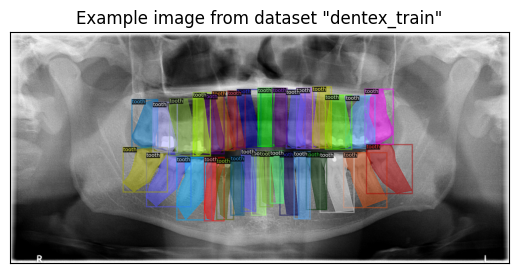

In [41]:
# Plot one image from the training set
def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

# Load one random image from the training set
dataset = 'dentex_train'
image_list = DatasetCatalog.get(dataset)
image_dict = np.random.choice(image_list, size=1)[0]
metadata = MetadataCatalog.get(dataset)
im = ImageData().load_image(image_dict.get('file_name'))
vs = Visualizer(img_rgb=im, metadata=metadata, scale = 1.0)
vs = vs.draw_dataset_dict(image_dict).get_image()
fig, ax = show_image(vs, figsize=(12, 3), title=f'Example image from dataset "{dataset}"')
plt.show()

In [42]:
# Model definition
# For a description, see https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
# configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml
# configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
model_config = os.path.join('COCO-InstanceSegmentation', 'mask_rcnn_R_101_FPN_3x.yaml')

# Build configuration file
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_config))

# Output directory
model_name = 'Toothsegment'
model_version = 1
model_output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')
Path(model_output_dir).mkdir(parents=True, exist_ok=True)

# Set the names for the datasets (as registered)
cfg.DATASETS.TRAIN = ('dentex_train', )
cfg.DATASETS.TEST = ('dentex_val', )
cfg.TEST.EVAL_PERIOD = 100
# The numbers of workers you can use depends on the number of cores and memory available per core
# Four workes is good for 32G memory
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)
# The batch size needs to be adjusted according to the GPU memory
# A batch size of 4 works for and 8 GB GPU
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = []
# Train for at least 3,000 iterations to get good results
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = model_output_dir

# Train on GPU or CPU
cfg.MODEL.DEVICE = device.type

# Save the config file before training
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(model_output_dir, model_config_file_name)
with open(model_config_file, mode='w') as fl:
    fl.write(cfg.dump())

In [43]:
# Train the model
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/14 10:12:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 151MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/14 10:12:02 d2.engine.train_loop]: Starting training from iteration 0
[10/14 10:12:15 d2.utils.events]:  eta: 0:10:13  iter: 19  total_loss: 4.841  loss_cls: 0.6765  loss_box_reg: 0.6509  loss_mask: 0.6915  loss_rpn_cls: 2.598  loss_rpn_loc: 0.2621    time: 0.6221  last_time: 0.5998  data_time: 0.0298  last_data_time: 0.0099   lr: 4.9953e-06  max_mem: 5399M
[10/14 10:12:27 d2.utils.events]:  eta: 0:10:00  iter: 39  total_loss: 2.68  loss_cls: 0.6444  loss_box_reg: 0.8204  loss_mask: 0.6895  loss_rpn_cls: 0.3117  loss_rpn_loc: 0.2267    time: 0.6247  last_time: 0.6278  data_time: 0.0098  last_data_time: 0.0098   lr: 9.9902e-06  max_mem: 5399M
[10/14 10:12:40 d2.utils.events]:  eta: 0:09:48  iter: 59  total_loss: 2.449  loss_cls: 0.6038  loss_box_reg: 0.8425  loss_mask: 0.6846  loss_rpn_cls: 0.09007  loss_rpn_loc: 0.2296    time: 0.6268  last_time: 0.6195  data_time: 0.0098  last_data_time: 0.0099   lr: 1.4985e-05  max_mem: 5400M
[10/14 10:12:53 d2.utils.events]:  eta: 0:09:37  iter:

In [44]:
# Imports
import os
import numpy as np
import pandas as pd
import json
import time
import glob
import random
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [45]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [46]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
output_dir_predictions = os.path.join(output_dir, 'predictions')
Path(output_dir_predictions).mkdir(parents=True, exist_ok=True)

# Data frame with data splits
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

# Annotation file for testdata
test_annotation_file_name = 'dentex_detection_test.json'
test_annotation_file = os.path.join(data_dir, test_annotation_file_name)

In [47]:
with open(test_annotation_file, 'r') as fl:
    annotations = json.load(fl)
dataset_name = 'dentex_test'
annotations_dict = {dataset_name: annotations}
if dataset_name not in DatasetCatalog:
    DatasetCatalog.register(name=dataset_name, func=lambda d=dataset_name: annotations_dict.get(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

In [48]:
# Let's see if we have a saved checkpoint. If not, use this one:
link = 'https://dsets.s3.amazonaws.com/dentex/toothdetection_3K.pth'

# The previous training notebook should have the defined model name
model_name = 'Toothdetector'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir,
                              model_name,
                              f'version_{model_version}')

last_checkpoint_name = 'model_final.pth'
last_checkpoint = glob.glob(os.path.join(checkpoint_dir, last_checkpoint_name))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "{last_checkpoint_name}" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "{last_checkpoint_name}" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "model_final.pth" in DATA_ROOT/model/Toothdetector/version_1.


In [49]:
output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')

# Load the config file. This was created right before training the model.
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(output_dir, model_config_file_name)

# Recreate the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_config_file)
cfg.MODEL.DEVICE = device.type
cfg.MODEL.WEIGHTS = checkpoint_file

# Create the dentex predictor instance
predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, 'dentex_test')

# Create COCO-Evaluator for the test set
evaluator = COCOEvaluator(dataset_name='dentex_test',
                          tasks=('bbox', ),
                          distributed=False,
                          output_dir=output_dir)

# Run model evaluation on test set
results = inference_on_dataset(predictor.model, val_loader, evaluator)
results_df = pd.DataFrame(results.get('bbox'), index=[0]).\
                assign(checkpoint=os.path.basename(checkpoint_file))
print()
display(results_df)

[10/14 10:30:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from DATA_ROOT/model/Toothdetector/version_1/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[10/14 10:30:42 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   tooth    | 1445         |
|            |              |
[10/14 10:30:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/14 10:30:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/14 10:30:42 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[10/14 10:30:42 d2.data.common]: Serialized dataset takes 0.21 MiB
[10/14 10:30:42 d2.evaluation.coco_evaluation]: Trying to convert 'dentex_test' to COCO format ...
[10/14 10:30:42 d2.data.datasets.coco]: Converting annotations of dataset 'dentex_test' to COCO format ...)
[10/14 10:30:42 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/14 10:30:42 d2.data.datasets.coco]: C

,AP,AP50,AP75,APs,APm,APl,checkpoint
0,52.903009,97.651543,51.774488,NaN,54.158416,52.995797,model_final.pth


In [50]:
files = pd.read_parquet(data_df_file)
files = files.loc[files['dataset']=='test'].\
                reset_index(drop=True)
display(files.head())

# A little helper function to get the rectangle width and height from the bounding box
# Bounding box outputs are:
# upper_left_corner_x, upper_left_corner_y, lower_right_corner_x, lower_right_corner_y
def rectangle(box):
    """ Create the rectangle paramters needed for matplotlib patches """
    width = box[2] - box[0]
    height = box[3] - box[1]
    anchor = (box[0], box[1])
    return anchor, width, height

def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

,image_id,file_name,image_number,file_path,dataset
0,601,train_298.png,298,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
1,222,train_365.png,365,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
2,478,train_595.png,595,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
3,451,train_517.png,517,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
4,160,train_467.png,467,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test


In [51]:
# Load the image
box_df_list = []
n_output_images = 15
for i, image_number in enumerate(files['image_number'].unique()[:n_output_images]):
    start_time = time.time()
    image_df = files.loc[files['image_number'] == image_number]
    image_file = image_df['file_path'].values[0]
    image_name = image_df['file_name'].values[0]
    im = ImageData().load_image(image_file)
    # Predict the bounding boxes for that image (list of tuples)
    pred = predictor(im).get('instances').to('cpu')
    pred_scores = list(pred.scores.numpy())
    pred_boxes = [tuple(np.round(box.numpy()).astype(int)) for box in pred.pred_boxes]
    # Create a list of colors for the rectangles
    color = cm.rainbow(np.linspace(0, 1, len(pred_boxes)))
    color_list = [color[c] for c in range(len(color))]
    random.shuffle(color_list)
    # Draw the image
    fig, ax = show_image(im, figsize=(9, 3))
    # Draw the bounding boxes
    for b, box in enumerate(pred_boxes):
        anchor, width, height = rectangle(box)
        box_dict = {'box_number': [b],
                    'box_score': [pred_scores[b]],
                    'anchor_xy': [anchor],
                    'width': [width],
                    'height': [height]}
        box_df_list.append(image_df.assign(**box_dict))
        rect = patches.Rectangle(xy=anchor,
                                 width=width,
                                 height=height,
                                 linewidth=1.5,
                                 edgecolor=color_list[b],
                                 facecolor='none',
                                 alpha=0.7)
        ax.add_patch(rect)
    ax.set(xticks=[], yticks=[])
    end_time = time.time()
    dt = (end_time - start_time)
    print()
    print(f'File {i+1} of {len(files)}: {image_name} with {len(pred_boxes)} bounding boxes.')
    print()
    print(f'The detection of the {len(pred_boxes)} teeth took {dt:.3f} seconds.')
    print()
    image_name = f'{os.path.splitext(image_name)[0]}_pred.png'
    plt.savefig(os.path.join(output_dir_predictions, image_name), bbox_inches='tight')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [52]:
# Imports
import os
import numpy as np
import pandas as pd
import json
import time
import glob
import random
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [53]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
output_dir_predictions = os.path.join(output_dir, 'segm_predictions')
Path(output_dir_predictions).mkdir(parents=True, exist_ok=True)

# Data frame with data splits
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

# Annotation file for testdata
test_annotation_file_name = 'dentex_detection_test.json'
test_annotation_file = os.path.join(data_dir, test_annotation_file_name)

In [54]:
with open(test_annotation_file, 'r') as fl:
    annotations = json.load(fl)
dataset_name = 'dentex_test'
annotations_dict = {dataset_name: annotations}
if dataset_name not in DatasetCatalog:
    DatasetCatalog.register(name=dataset_name, func=lambda d=dataset_name: annotations_dict.get(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

In [55]:
# Let's see if we have a saved checkpoint. If not, use this one:
link = 'https://dsets.s3.amazonaws.com/dentex/toothsegmentation_1K.pth'

# The previous training notebook should have the defined model name
model_name = 'Toothsegment'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir,
                              model_name,
                              f'version_{model_version}')

last_checkpoint_name = 'model_final.pth'
last_checkpoint = glob.glob(os.path.join(checkpoint_dir, last_checkpoint_name))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "{last_checkpoint_name}" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "{last_checkpoint_name}" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "model_final.pth" in DATA_ROOT/model/Toothsegment/version_1.


In [56]:
output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')

# Load the config file. This was created right before training the model.
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(output_dir, model_config_file_name)

# Recreate the model configuration
cfg = get_cfg()
cfg.merge_from_file(model_config_file)
cfg.MODEL.DEVICE = device.type
cfg.MODEL.WEIGHTS = checkpoint_file

# Create the dentex predictor instance
predictor = DefaultPredictor(cfg)
val_loader = build_detection_test_loader(cfg, 'dentex_test')

# Create COCO-Evaluator for the test set
evaluator = COCOEvaluator(dataset_name='dentex_test',
                          tasks=('bbox', 'segm', ),
                          distributed=False,
                          output_dir=output_dir)

# Run model evaluation on test set
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Combine test results on bounding boxes and segmentations into one table
results_df_list = []
for task in ['bbox', 'segm']:
    results_df_task = pd.DataFrame(results.get(task), index=[0]).\
                    assign(checkpoint=os.path.basename(checkpoint_file),
                           task=task)
    results_df_list.append(results_df_task)
results_df = pd.concat(results_df_list, axis=0, ignore_index=True)
print()
display(results_df)

[10/14 10:33:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from DATA_ROOT/model/Toothsegment/version_1/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[10/14 10:33:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/14 10:33:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/14 10:33:51 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[10/14 10:33:51 d2.data.common]: Serialized dataset takes 0.21 MiB
[10/14 10:33:51 d2.evaluation.evaluator]: Start inference on 50 batches
[10/14 10:33:55 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0013 s/iter. Inference: 0.0806 s/iter. Eval: 0.2374 s/iter. Total: 0.3193 s/iter. ETA=0:00:12
[10/14 10:34:01 d2.evaluation.evaluator]: Inference done 27/50. Dataloading: 0.0016 s/iter. Inference: 0.0803 s/iter. Eval: 0.2426 s/iter. Total: 0.3248 s/iter. ETA=0:00:07
[10/14 10:34:06 d2.evaluation.evaluator]: Inference done 43/50. Dataloading: 0.0017 s/iter. Inference: 0.0804 s/it

,AP,AP50,AP75,APs,APm,APl,checkpoint,task
0,53.697474,97.771988,51.037637,NaN,55.730198,53.762449,model_final.pth,bbox
1,51.930311,97.735344,49.848768,NaN,43.673508,52.130083,model_final.pth,segm


In [57]:
files = pd.read_parquet(data_df_file)
files = files.loc[files['dataset']=='test'].\
                reset_index(drop=True)
display(files.head())

def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

,image_id,file_name,image_number,file_path,dataset
0,601,train_298.png,298,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
1,222,train_365.png,365,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
2,478,train_595.png,595,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
3,451,train_517.png,517,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test
4,160,train_467.png,467,DATA_ROOT/dentex/dentex_detection/quadrant_enu...,test


In [58]:
# Load the image
box_df_list = []
n_output_images = 15
image_number_list = files['image_number'].unique()[:n_output_images]

for i, image_number in enumerate(image_number_list):
    start_time = time.time()
    image_df = files.loc[files['image_number'] == image_number]
    image_file = image_df['file_path'].values[0]
    image_name = image_df['file_name'].values[0]
    im = ImageData().load_image(image_file)
    # Instance segmentation predictions for this image
    pred = predictor(im)
    n_instances = len(pred.get('instances'))
    # Visualizer
    metadata = MetadataCatalog.get('dentex_test')
    vis = Visualizer(img_rgb=im, metadata=metadata, scale = 1.2)
    vis = vis.draw_instance_predictions(pred.get('instances').to('cpu'))
    fig, ax = show_image(vis.get_image(), figsize=(12, 6))
    dt = (time.time() - start_time)
    print()
    print(f'File {i + 1} of {len(image_number_list)}: {image_name} with {n_instances} instances.')
    print()
    print(f'The detection of the {n_instances} segmentations took {dt:.3f} seconds.')
    print()

    image_name = f'{os.path.splitext(image_name)[0]}_pred.png'
    plt.savefig(os.path.join(output_dir_predictions, image_name), bbox_inches='tight')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.